# Intro to Object Detection Colab

Welcome to the object detection colab!  This demo will take you through the steps of running an "out-of-the-box" detection model on a collection of images.

## Setup

In [1]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

In [ ]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

## Import and start

In [1]:
import matplotlib
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf



%matplotlib inline

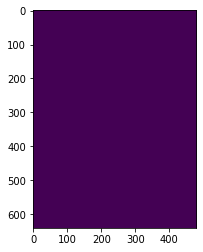

In [2]:
foo = np.zeros((640,480))
plt.imshow(foo)

## Utilities

In [3]:
from bricks.CenterNet import CenterNet
from bricks.XCeptionImageNet import XCeptionImageNet
import os

model_display_name = ['xception_imagenet','centernet_with_keypoints'] # @param ['centernet_with_keypoints', 'centernet_without_keypoints', 'xception_imagenet']


loaded_models = []

if 'centernet_with_keypoints' in model_display_name:
    if(not os.path.exists("centernet_hg104_512x512_kpts_coco17_tpu-32")):
        !wget http://download.tensorflow.org/models/object_detection/tf2/20200711/centernet_hg104_512x512_kpts_coco17_tpu-32.tar.gz
        !tar -xf centernet_hg104_512x512_kpts_coco17_tpu-32.tar.gz
        !mv centernet_hg104_512x512_kpts_coco17_tpu-32/checkpoint models/research/object_detection/test_data/
    loaded_models.append(
        CenterNet(
            pipeline_config = 'models/research/object_detection/configs/tf2/center_net_hourglass104_512x512_coco17_tpu-8.config', 
            model_dir = 'models/research/object_detection/test_data/checkpoint/'
        )
    )
if 'centernet_without_keypoints' in model_display_name:
    if(not os.path.exists("centernet_hg104_512x512_kpts_coco17_tpu-32")):
        !wget http://download.tensorflow.org/models/object_detection/tf2/20200711/centernet_hg104_512x512_coco17_tpu-8.tar.gz
        !tar -xf centernet_hg104_512x512_coco17_tpu-8.tar.gz
        !mv centernet_hg104_512x512_coco17_tpu-8/checkpoint models/research/object_detection/test_data/
    loaded_models.append(
        CenterNet(
            pipeline_config = '../models/research/object_detection/configs/tf2/center_net_hourglass104_512x512_coco17_tpu-8.config', 
            model_dir = '../models/research/object_detection/test_data/checkpoint/'
        )
    )
if 'xception_imagenet' in model_display_name:
    loaded_models.append(XCeptionImageNet())

In [18]:
#image_path = '/mnt/c/Users/alessandro.colombo/Pictures/fanart.tv/backgrounds/a-bittersweet-life___a-bittersweet-life-504a3db1a12e6.jpg'
image_path = '/mnt/c/Users/alessandro.colombo/Pictures/fanart.tv/backgrounds/a-brief-history-of-time___a-brief-history-of-time-532661477b720.jpg'

In [19]:
from tensorflow import keras

img = keras.preprocessing.image.load_img(image_path)
img_array = keras.preprocessing.image.img_to_array(img)

detections = np.zeros((img_array.shape[0], img_array.shape[1]))
for model_instance in loaded_models:
    detections += model_instance.get_detections(image_path)

/mnt/c/Users/alessandro.colombo/workspace/imagecrop/bricks/XCeptionImageNet.py:64: RuntimeWarning: invalid value encountered in true_divide
  heatmap /= np.max(heatmap)


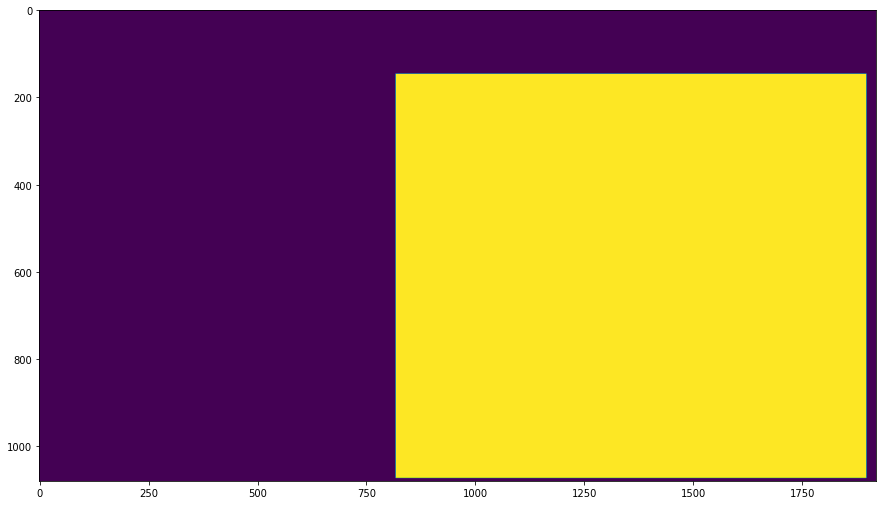

In [20]:
plt.figure(figsize=(15,20))
plt.imshow(detections)

### Superimpose detection to image

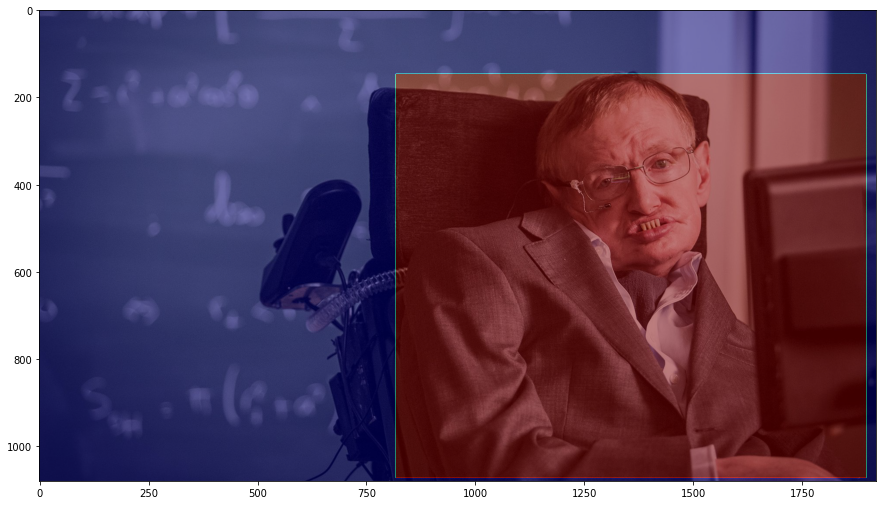

In [21]:
from tensorflow import keras
import matplotlib.cm as cm

#detection_plus = np.expand_dims(detections, axis=-1)


img = keras.preprocessing.image.load_img(image_path)
# img = keras.preprocessing.image.img_to_array(img)
#superimposed_img = detections * 4 + img
#superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

plt.figure(figsize=(15,20))
plt.imshow(img)
plt.imshow(detections, cmap='jet', alpha=0.5)

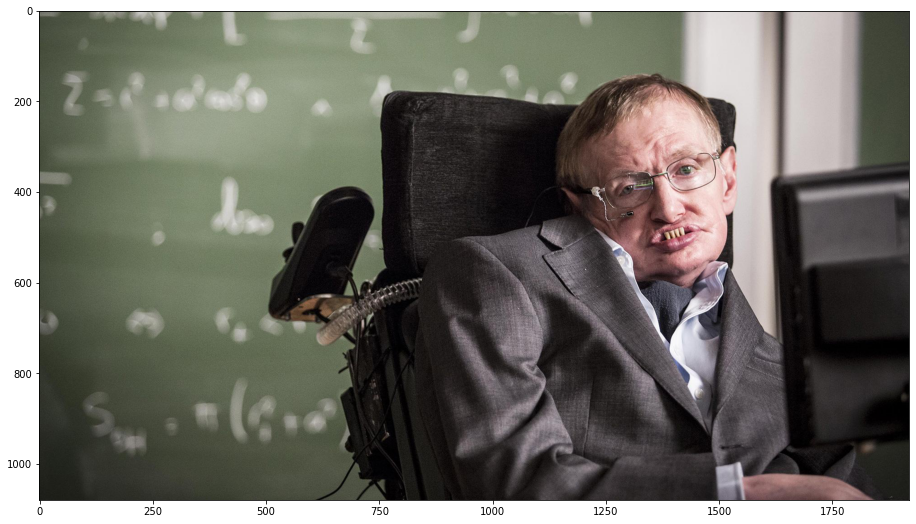

In [22]:
orig_im = Image.open(image_path)
plt.figure(figsize=(16,9))
plt.imshow(orig_im)

BEST: (823.5, 54.0, 1399.5, 1077.0)


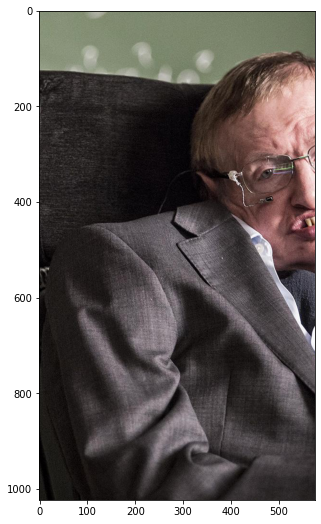

In [24]:
from utilities import *

crops = make_crop_coordinates_nhz(detections,"9_16")

best_score = -1
best_crop = []

for crop in crops:
    #TODO: add rule of thirds, avoid partial classes crop,etc.. to the score
    candidate_score = np.sum(detections[int(crop[1]):int(crop[3]),int(crop[0]):int(crop[2])])
    #print(crop)
    #print(candidate_score)
    if best_score < candidate_score:
        best_crop = crop
        best_score = candidate_score
        
print("BEST:",best_crop)
if best_crop:
    plt.figure(figsize=(16,9))
    #plt.imshow(np_im[int(best_crop[1]):int(best_crop[3]),int(best_crop[0]):int(best_crop[2])])
    plt.imshow(orig_im.crop(best_crop))
else:
    print("No candidates")